# Train an image classifier

In this tutorial, we show how to train a simple convolutional neural network (CNN) to classify hand-written digits from the MNIST dataset.

In [1]:
import math
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pax
import opax
from absl import logging

In [2]:
logging.set_verbosity(logging.FATAL)
pax.seed_rng_key(42)
learning_rate = 1e-4
batch_size = 128
num_training_steps = 1000

First, we will load the MNIST dataset using `tensorflow_datasets` library and show a few examples.

In [3]:
mnist_data = tfds.load("mnist")

In [4]:
def plot_image_grid(images, labels):
    N = len(images)
    size = int(math.sqrt(N))
    plt.figure(figsize=(size, size))
    for i in range(N):
        plt.subplot(size, size, i + 1)
        plt.imshow(images[i, ..., 0])
        plt.text(0, -1, labels[i])
        plt.axis("off")
    plt.show()

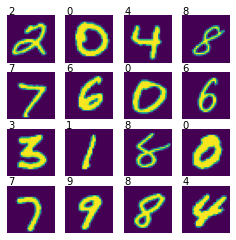

In [5]:
batch = next(mnist_data["test"].take(16).batch(16).as_numpy_iterator())
plot_image_grid(batch["image"], batch["label"])

Now, we will use `PAX` to implement a simple CNN model:

In [6]:
net = pax.nn.Sequential(
    pax.nn.Conv2D(1, 32, 5, stride=1, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(32, 64, 5, stride=2, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(64, 128, 3, stride=2, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(128, 10, 4, stride=1, padding="VALID"),
    lambda x: x.reshape((x.shape[0], -1)),
)

We use `pax.nn.Sequential` to define a module as a sequence of computational steps. 

In [7]:
print(net.summary())

Sequential
├── Conv2D(in_features=1, out_features=32, kernel_shape=(5, 5), padding=VALID, with_bias=True, data_format=NHWC)
├── x => relu(x)
├── Conv2D(in_features=32, out_features=64, kernel_shape=(5, 5), padding=VALID, stride=(2, 2), with_bias=True, data_format=NHWC)
├── x => relu(x)
├── Conv2D(in_features=64, out_features=128, kernel_shape=(3, 3), padding=VALID, stride=(2, 2), with_bias=True, data_format=NHWC)
├── x => relu(x)
├── Conv2D(in_features=128, out_features=10, kernel_shape=(4, 4), padding=VALID, with_bias=True, data_format=NHWC)
└── x => <lambda>(x)


Next, we plot the predictions of the untrained model as a simple sanity check. Note that we are normalizing MNIST images to the range of $[-1, 1]$, which is a preferred range for neural nets.

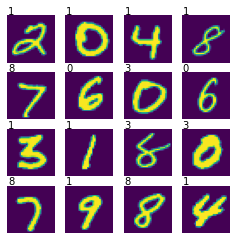

In [8]:
images = batch["image"].astype(jnp.float32) / 255.0 * 2.0 - 1.0
logits = net(images)
labels = jnp.argmax(logits, axis=-1)
plot_image_grid(images, labels)

We will use a *cross-entropy* loss function to train our model.

In [9]:
def loss_fn(model: pax.Module, inputs):
    images, labels = inputs["image"], inputs["label"]
    images = images.astype(jnp.float32) / 255.0 * 2.0 - 1.0
    logits = model(images)
    log_prs = jax.nn.log_softmax(logits)
    log_prs = jax.nn.one_hot(labels, num_classes=logits.shape[-1]) * log_prs
    log_pr = jnp.sum(log_prs, axis=-1)
    loss = -jnp.mean(log_pr)
    return loss

We need an update function that represents a single training step.

In [10]:
@jax.jit
def update_fn(model: pax.Module, optimizer: opax.GradientTransformation, inputs):
    loss, grads = jax.value_and_grad(loss_fn)(model, inputs)
    model, optimizer = opax.apply_gradients(model, optimizer, grads=grads)
    return model, optimizer, loss

We use the `opax.apply_gradients` function to update both the model and the optimizer.

Now, let's create a data loader.

In [11]:
dataloader = (
    mnist_data["train"]
    .repeat()
    .shuffle(100 * batch_size)
    .batch(batch_size)
    .take(num_training_steps)
    .prefetch(1)
    .enumerate(1)
    .as_numpy_iterator()
)

We will use ``adam`` optimizer from ``opax`` library.

In [12]:
optimizer = opax.adam(learning_rate)(net.parameters())

Finally, let's train our model.

In [13]:
total_losses = 0.0
for step, inputs in dataloader:
    net, optimizer, loss = update_fn(net, optimizer, inputs)
    total_losses = loss + total_losses
    if step % 100 == 0:
        loss = total_losses / 100
        total_losses = 0.0
        print(f"[step {step:>4}]  loss {loss:.3f}")

[step  100]  loss 1.153
[step  200]  loss 0.363
[step  300]  loss 0.271
[step  400]  loss 0.201
[step  500]  loss 0.180
[step  600]  loss 0.145
[step  700]  loss 0.133
[step  800]  loss 0.118
[step  900]  loss 0.116
[step 1000]  loss 0.100


Let's plot the predictions of our trained model on the _test_ set as a simple sanity check.

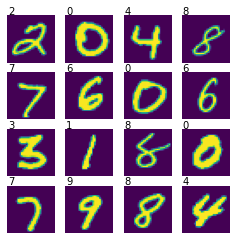

In [14]:
batch = next(mnist_data["test"].take(16).batch(16).as_numpy_iterator())
images = batch["image"].astype(jnp.float32) / 255.0 * 2.0 - 1.0  # [-1, 1]
logits = net(images)
labels = jnp.argmax(logits, axis=-1)
plot_image_grid(images, labels)